In [1]:
# ============================================
# Hurricane Size Predictor — RandomForest Only
# ============================================
import numpy as np
import pandas as pd
import re, math, os, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import joblib

import matplotlib.pyplot as plt

print("✅ Libraries loaded")



✅ Libraries loaded


In [3]:
# OPTION A: upload manually
# from google.colab import files
# uploaded = files.upload()
# csv_path = next(iter(uploaded))

# OPTION B: point to an existing file path in /content
csv_path = "/content/Hurricane_dataset - Sheet1.csv"  # <-- adjust if needed

df = pd.read_csv(csv_path)
print("Initial shape:", df.shape)
df.head()



Initial shape: (170, 15)


,num,Date,Time,Lat,Long,Max_Winds_kt,SSHWS,RMW_nm,Central_Pressure,OCI_mb,Size_nm,States_Affected,Strom_Name,Unnamed: 13,Unnamed: 14
0,1,7/11/1901,0700Z,36.0N,75.8W,70,1,---,-983,1013,175,NC1,---------------,NaN,NaN
1,2,8/14/1901,2100Z,29.3N,89.6W,75,1,---,-973,1010,300,LA1,---------------,NaN,NaN
2,3,8/15/1901,1700Z,30.4N,88.8W,75,1,35,973,1010,300,"MS1,AL1",---------------,NaN,NaN
3,4,9/11/1903,2300Z,26.1N,80.1W,75,1,45,976,1013,150,CFL1,---------------,NaN,NaN
4,5,9/13/1903,2300Z,30.1N,85.6W,80,1,---,-974,1014,200,AFL1,---------------,NaN,NaN


In [4]:
# Drop unnamed/junk columns if any
for c in list(df.columns):
    if "Unnamed" in c:
        df.drop(columns=c, inplace=True, errors="ignore")

# Normalize column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# --- Parsers ---
def parse_lat(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    m = re.match(r"^([+-]?\d+(?:\.\d+)?)([NnSs])$", s)
    if m:
        val = float(m.group(1))
        return val if m.group(2).upper()=="N" else -val
    try: return float(s)
    except: return np.nan

def parse_lon(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    m = re.match(r"^([+-]?\d+(?:\.\d+)?)([EeWw])$", s)
    if m:
        val = float(m.group(1))
        return -val if m.group(2).upper()=="W" else val
    try: return float(s)
    except: return np.nan

def parse_rmw(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s in {"---","--","-"}: return np.nan
    s = s.replace(",", "")
    try: return float(s)
    except: return np.nan

def parse_pressure(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", "")
    m = re.match(r"^\(?\s*(-?\d+(?:\.\d+)?)\s*\)?$", s)  # handles (983) or -983
    if m: return abs(float(m.group(1)))
    try: return abs(float(s))
    except: return np.nan

def parse_time_to_hour(t):
    if pd.isna(t): return np.nan
    s = str(t).strip().upper().replace("Z","")
    m = re.match(r"^(\d{2})(\d{2})$", s)  # 2300 -> 23
    if m: return int(m.group(1))
    try:
        h = int(s)
        return h if 0 <= h <= 23 else np.nan
    except:
        return np.nan

print("✅ Cleaning helpers ready")


✅ Cleaning helpers ready


In [5]:
# Parse columns (only if present)
if "Lat" in df.columns: df["Lat"] = df["Lat"].apply(parse_lat)
if "Long" in df.columns: df["Long"] = df["Long"].apply(parse_lon)
if "RMW_nm" in df.columns: df["RMW_nm"] = df["RMW_nm"].apply(parse_rmw)

if "Central_Pressure" in df.columns: df["Central_Pressure"] = df["Central_Pressure"].apply(parse_pressure)
if "OCI_mb" in df.columns: df["OCI_mb"] = pd.to_numeric(df["OCI_mb"], errors="coerce")

# Date & time to numeric parts
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Year"]  = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"]   = df["Date"].dt.day

if "Time" in df.columns:
    df["Hour"] = df["Time"].apply(parse_time_to_hour)

# Simple derived features
if "Lat" in df.columns:
    df["Abs_Lat"] = df["Lat"].abs()
if {"Max_Winds_kt", "Central_Pressure"}.issubset(df.columns):
    df["Wind_to_Pressure"] = df["Max_Winds_kt"] / (df["Central_Pressure"] + 1e-6)

print("After cleaning shape:", df.shape)
df.head()


After cleaning shape: (170, 19)


,num,Date,Time,Lat,Long,Max_Winds_kt,SSHWS,RMW_nm,Central_Pressure,OCI_mb,Size_nm,States_Affected,Strom_Name,Year,Month,Day,Hour,Abs_Lat,Wind_to_Pressure
0,1,1901-07-11,0700Z,36.0,-75.8,70,1,NaN,983.0,1013,175,NC1,---------------,1901.0,7.0,11.0,7,36.0,0.071211
1,2,1901-08-14,2100Z,29.3,-89.6,75,1,NaN,973.0,1010,300,LA1,---------------,1901.0,8.0,14.0,21,29.3,0.077081
2,3,1901-08-15,1700Z,30.4,-88.8,75,1,35.0,973.0,1010,300,"MS1,AL1",---------------,1901.0,8.0,15.0,17,30.4,0.077081
3,4,1903-09-11,2300Z,26.1,-80.1,75,1,45.0,976.0,1013,150,CFL1,---------------,1903.0,9.0,11.0,23,26.1,0.076844
4,5,1903-09-13,2300Z,30.1,-85.6,80,1,NaN,974.0,1014,200,AFL1,---------------,1903.0,9.0,13.0,23,30.1,0.082136


In [6]:
TARGET = "Size_nm"

# Drop clearly non-predictive or text-heavy columns if they exist
drop_cols = [c for c in ["num","Date","Time","States_Affected","Strom_Name","Storm_Name"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")

# Ensure target present and drop missing target rows
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns: {list(df.columns)}")

df = df.dropna(subset=[TARGET]).copy()

# Numeric-only features
feature_cols = [c for c in df.columns if c != TARGET]
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Impute numeric features with median
X = df[feature_cols].fillna(df[feature_cols].median(numeric_only=True))
y = df[TARGET].astype(float)

print("Features:", X.shape, "Target:", y.shape)
X.head()


Features: (170, 13) Target: (170,)


,Lat,Long,Max_Winds_kt,SSHWS,RMW_nm,Central_Pressure,OCI_mb,Year,Month,Day,Hour,Abs_Lat,Wind_to_Pressure
0,36.0,-75.8,70,1,20.0,983.0,1013,1901.0,7.0,11.0,7,36.0,0.071211
1,29.3,-89.6,75,1,20.0,973.0,1010,1901.0,8.0,14.0,21,29.3,0.077081
2,30.4,-88.8,75,1,35.0,973.0,1010,1901.0,8.0,15.0,17,30.4,0.077081
3,26.1,-80.1,75,1,45.0,976.0,1013,1903.0,9.0,11.0,23,26.1,0.076844
4,30.1,-85.6,80,1,20.0,974.0,1014,1903.0,9.0,13.0,23,30.1,0.082136


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (127, 13) Val: (21, 13) Test: (22, 13)


In [8]:
# Dummy baseline (predict mean)
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# RandomForest (strong default for tabular, small data)
rf = RandomForestRegressor(
    n_estimators=400,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("✅ Models trained (Dummy + RandomForest)")


✅ Models trained (Dummy + RandomForest)


In [9]:
def evaluate(y_true, y_pred, name="Model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    within_50  = (np.abs(y_true - y_pred) < 50).mean() * 100
    within_100 = (np.abs(y_true - y_pred) < 100).mean() * 100
    print(f"{name} — MAE: {mae:.2f} nm | RMSE: {rmse:.2f} nm | R²: {r2:.3f} | "
          f"±50 nm: {within_50:.1f}% | ±100 nm: {within_100:.1f}%")
    return {"MAE":mae, "RMSE":rmse, "R2":r2, "within50":within_50, "within100":within_100}

pred_dummy = dummy.predict(X_test)
pred_rf    = rf.predict(X_test)

metrics_dummy = evaluate(y_test, pred_dummy, "DummyMean")
metrics_rf    = evaluate(y_test, pred_rf,    "RandomForest")


DummyMean — MAE: 65.93 nm | RMSE: 80.38 nm | R²: -0.066 | ±50 nm: 36.4% | ±100 nm: 72.7%
RandomForest — MAE: 29.97 nm | RMSE: 35.64 nm | R²: 0.790 | ±50 nm: 81.8% | ±100 nm: 100.0%


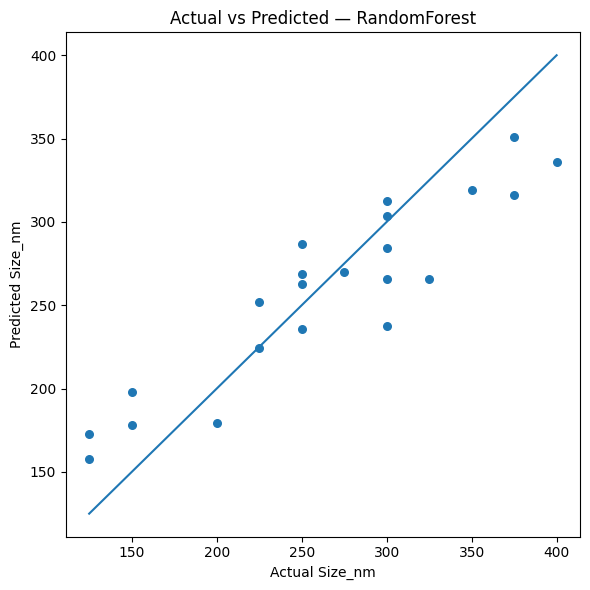

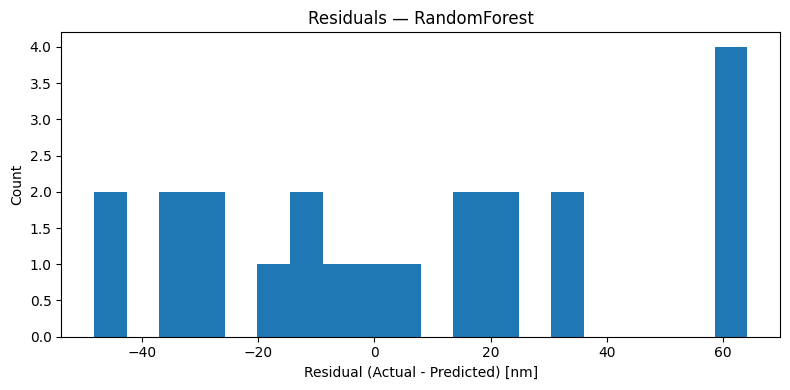

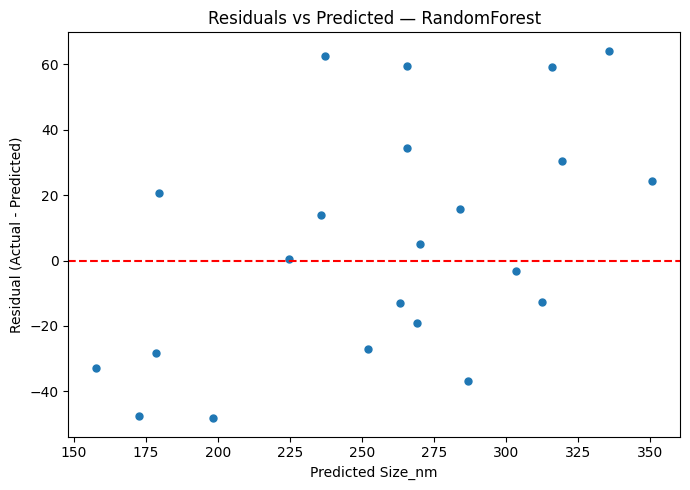

In [10]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf, s=30)
mn = float(min(y_test.min(), pred_rf.min()))
mx = float(max(y_test.max(), pred_rf.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual Size_nm")
plt.ylabel("Predicted Size_nm")
plt.title("Actual vs Predicted — RandomForest")
plt.tight_layout()
plt.show()

# Residuals histogram
res = y_test.values - pred_rf
plt.figure(figsize=(8,4))
plt.hist(res, bins=20)
plt.xlabel("Residual (Actual - Predicted) [nm]")
plt.ylabel("Count")
plt.title("Residuals — RandomForest")
plt.tight_layout()
plt.show()

# Residuals vs Predicted (check heteroscedasticity)
plt.figure(figsize=(7,5))
plt.scatter(pred_rf, res, s=25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted Size_nm")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted — RandomForest")
plt.tight_layout()
plt.show()


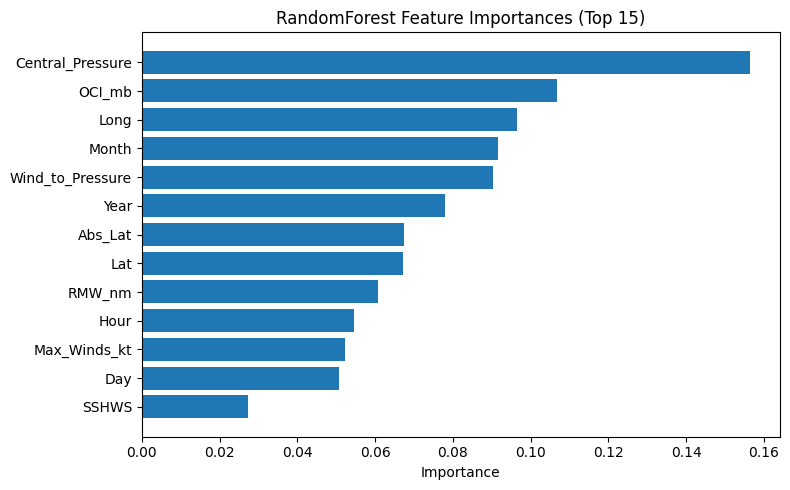

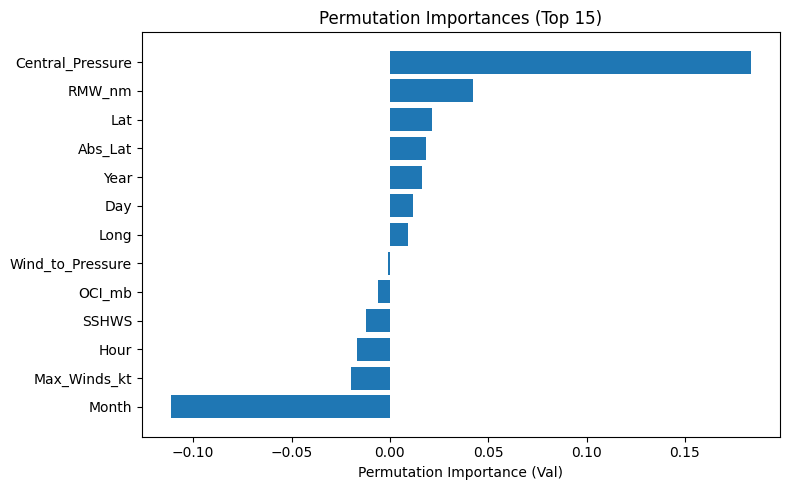

Top drivers (Permutation):
Central_Pressure    0.183574
RMW_nm              0.042430
Lat                 0.021199
Abs_Lat             0.018179
Year                0.016379
Day                 0.011593
Long                0.009405
Wind_to_Pressure   -0.000766
OCI_mb             -0.005887
SSHWS              -0.012029
dtype: float64


In [11]:
# Gini importance (built-in)
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.xlabel("Importance")
plt.title("RandomForest Feature Importances (Top 15)")
plt.tight_layout()
plt.show()

# Permutation importance (more reliable on correlated features)
perm = permutation_importance(rf, X_val, y_val, n_repeats=20, random_state=42, n_jobs=-1)
perm_importance = pd.Series(perm.importances_mean, index=X_val.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
plt.barh(perm_importance.index[::-1], perm_importance.values[::-1])
plt.xlabel("Permutation Importance (Val)")
plt.title("Permutation Importances (Top 15)")
plt.tight_layout()
plt.show()

print("Top drivers (Permutation):")
print(perm_importance.head(10))


In [12]:
# Predictions file
out = pd.DataFrame({
    "Actual": y_test.values,
    "RF_Predicted": pred_rf
}, index=y_test.index).join(X_test)
pred_path = "/content/hurricane_rf_predictions.csv"
out.to_csv(pred_path, index=False)

# Save model & feature list
model_path = "/content/hurricane_rf_model.joblib"
joblib.dump(rf, model_path)

feat_path = "/content/hurricane_feature_columns.txt"
with open(feat_path, "w") as f:
    for c in X.columns: f.write(c + "\n")

print("✅ Saved predictions to:", pred_path)
print("✅ Saved model to:", model_path)
print("✅ Saved feature list to:", feat_path)

# Optional: download in Colab
# from google.colab import files
# for p in [pred_path, model_path, feat_path]: files.download(p)


✅ Saved predictions to: /content/hurricane_rf_predictions.csv
✅ Saved model to: /content/hurricane_rf_model.joblib
✅ Saved feature list to: /content/hurricane_feature_columns.txt


In [13]:
# ===== Simple one-cell inference using the trained RandomForest =====
import numpy as np
import pandas as pd

# 1) Edit these metrics for the hurricane you want to score
sample = {
    "Lat": 25.3,                 # degrees north positive, south negative
    "Long": -80.6,               # west negative, east positive
    "Central_Pressure": 965,     # mb
    "Max_Winds_kt": 90,          # knots
    "RMW_nm": 25,                # nm
    "OCI_mb": 1010,              # mb
    "SSHWS": 2,                  # Saffir–Simpson category if available
    "Year": 2005,
    "Month": 9,
    "Day": 20,
    "Hour": 12
}

# 2) Minimal derived features used by the model
sample["Abs_Lat"] = abs(sample["Lat"])
sample["Wind_to_Pressure"] = sample["Max_Winds_kt"] / (sample["Central_Pressure"] + 1e-6)

# 3) Align to training columns (X.columns) and impute any missing with training medians
feature_cols = list(X.columns)              # from your training session
X_medians = X.median(numeric_only=True)     # training medians used earlier

row = {c: sample.get(c, np.nan) for c in feature_cols}
x_new = pd.DataFrame([row])
x_new = x_new.fillna(X_medians).fillna(0.0)

# 4) Predict
pred_nm = rf.predict(x_new)[0]
print(f"🔮 Predicted Size_nm: {pred_nm:.2f}")

🔮 Predicted Size_nm: 277.31


In [14]:
# Enter the actual observed size (in nm) for this hurricane
actual_size_nm = 300  # <-- change this to the true known value

# Compute absolute and percentage error
abs_error = abs(actual_size_nm - pred_nm)
pct_error = (abs_error / actual_size_nm) * 100

print(f"📏 Actual Size_nm: {actual_size_nm:.2f}")
print(f"🔮 Predicted Size_nm: {pred_nm:.2f}")
print(f"⚖️ Absolute Error: {abs_error:.2f} nm")
print(f"📊 Percentage Error: {pct_error:.2f}%")


📏 Actual Size_nm: 300.00
🔮 Predicted Size_nm: 277.31
⚖️ Absolute Error: 22.69 nm
📊 Percentage Error: 7.56%
